In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from tensorflow import keras
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from tensorflow import keras
np.random.seed(0) # sets random seeds for reproducibility of results using numpy and tensorflow
import tensorflow as tf
tf.random.set_seed(1)
import joblib

import warnings
warnings.filterwarnings('ignore')

In [26]:
#  Loads training and testing datasets
train = pd.read_csv('../data/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding='latin1')
test = pd.read_csv('../data/covid-19-nlp-text-classification/Corona_NLP_test.csv', encoding='latin1')

# Concatenates the two datasets into a single DataFrame
df = pd.concat([train, test])
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative


In [27]:
df.info() # Displays information about the combined dataset 

<class 'pandas.core.frame.DataFrame'>
Index: 44955 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Location       35531 non-null  object
 3   TweetAt        44955 non-null  object
 4   OriginalTweet  44955 non-null  object
 5   Sentiment      44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.4+ MB


In [28]:
# cleans the data
# Removes irrelevant columns (UserName, ScreenName, Location, TweetAt) from the dataset
df.drop(['UserName', 'ScreenName', 'Location', 'TweetAt'], axis=1, inplace=True)
df

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...
3793,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,Did you panic buy a lot of non-perishable item...,Negative
3795,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,Gov need to do somethings instead of biar je r...,Extremely Negative


In [29]:
# Ensures the dataset has no duplicate rows.
df.drop_duplicates(inplace=True)
df

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...
3793,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,Did you panic buy a lot of non-perishable item...,Negative
3795,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,Gov need to do somethings instead of biar je r...,Extremely Negative


<Axes: xlabel='Sentiment', ylabel='count'>

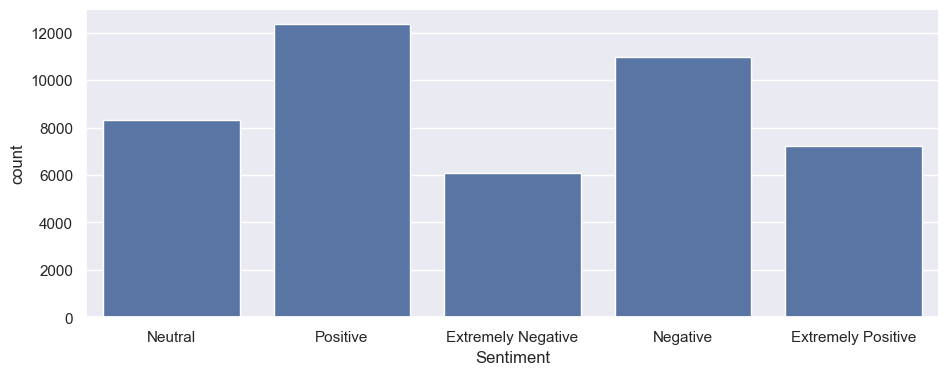

In [30]:
# Creates a bar plot showing the distribution of different sentiment categories using seaborn
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(11,4)})
sns.countplot(x='Sentiment', data=df)

In [31]:
# Counts the occurrences of each sentiment.
df['Sentiment'].value_counts()

Sentiment
Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: count, dtype: int64

In [32]:
# Mapping: Converts detailed sentiment categories
df.replace(['Extremely Negative', 'Extremely Positive','Extremely Pos'], ['Negative', 'Positive','Positive'], inplace=True)

# updates Counts: Verifies the counts of updated sentiment categories
df['Sentiment'].value_counts()

Sentiment
Positive    19592
Negative    17031
Neutral      8332
Name: count, dtype: int64

In [33]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/kale/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [34]:
import re
import nltk
nltk.download('punkt') # At first you have to download these nltk packages.
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = stopwords.words('english') # defining stop_words
stop_words.remove('not') # removing not from the stop_words list as it contains value in negative movies
lemmatizer = WordNetLemmatizer()

def nlpPreprocessing(tweet):
    # Data cleaning
    tweet = re.sub(r'@\w+', '', tweet)  # Remove mentions
    tweet = re.sub(r'#\w+', '', tweet)  # Remove hashtags
    tweet = re.sub(r'https?://\S+|www\.\S+', '', tweet)  # Remove URLs
    tweet = re.sub(r'<.*?>', '', tweet)  # Remove HTML tags
    tweet = re.sub('[^A-Za-z]+', ' ', tweet)  # Keep only alphabetic characters

    # Convert to lowercase
    tweet = tweet.lower()

    # Tokenization
    tokens = nltk.word_tokenize(tweet)  # Convert text to tokens

    # Remove single-character tokens (except meaningful ones like 'i' and 'a')
    tokens = [word for word in tokens if len(word) > 1]

    # Remove stopwords
    tweet = [word for word in tokens if word not in stop_words]

    # Lemmatization
    tweet = [lemmatizer.lemmatize(word) for word in tweet]

    # Join words back into a single string
    tweet = ' '.join(tweet)

    return tweet

[nltk_data] Downloading package punkt to /Users/kale/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/kale/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kale/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [35]:
# !unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

In [36]:

# Applies Preprocessing: Cleans the OriginalTweet column.
df['OriginalTweet'] = df['OriginalTweet'].apply(nlpPreprocessing)
df.head()

,OriginalTweet,Sentiment
0,,Neutral
1,advice talk neighbour family exchange phone nu...,Positive
2,coronavirus australia woolworth give elderly d...,Positive
3,food stock not one empty please panic enough f...,Positive
4,ready go supermarket outbreak not paranoid foo...,Negative


In [37]:
df['Sentiment'] = df['Sentiment'].apply(lambda x: x.lower())
df.head()

,OriginalTweet,Sentiment
0,,neutral
1,advice talk neighbour family exchange phone nu...,positive
2,coronavirus australia woolworth give elderly d...,positive
3,food stock not one empty please panic enough f...,positive
4,ready go supermarket outbreak not paranoid foo...,negative


In [38]:
# !pip install WordCloud

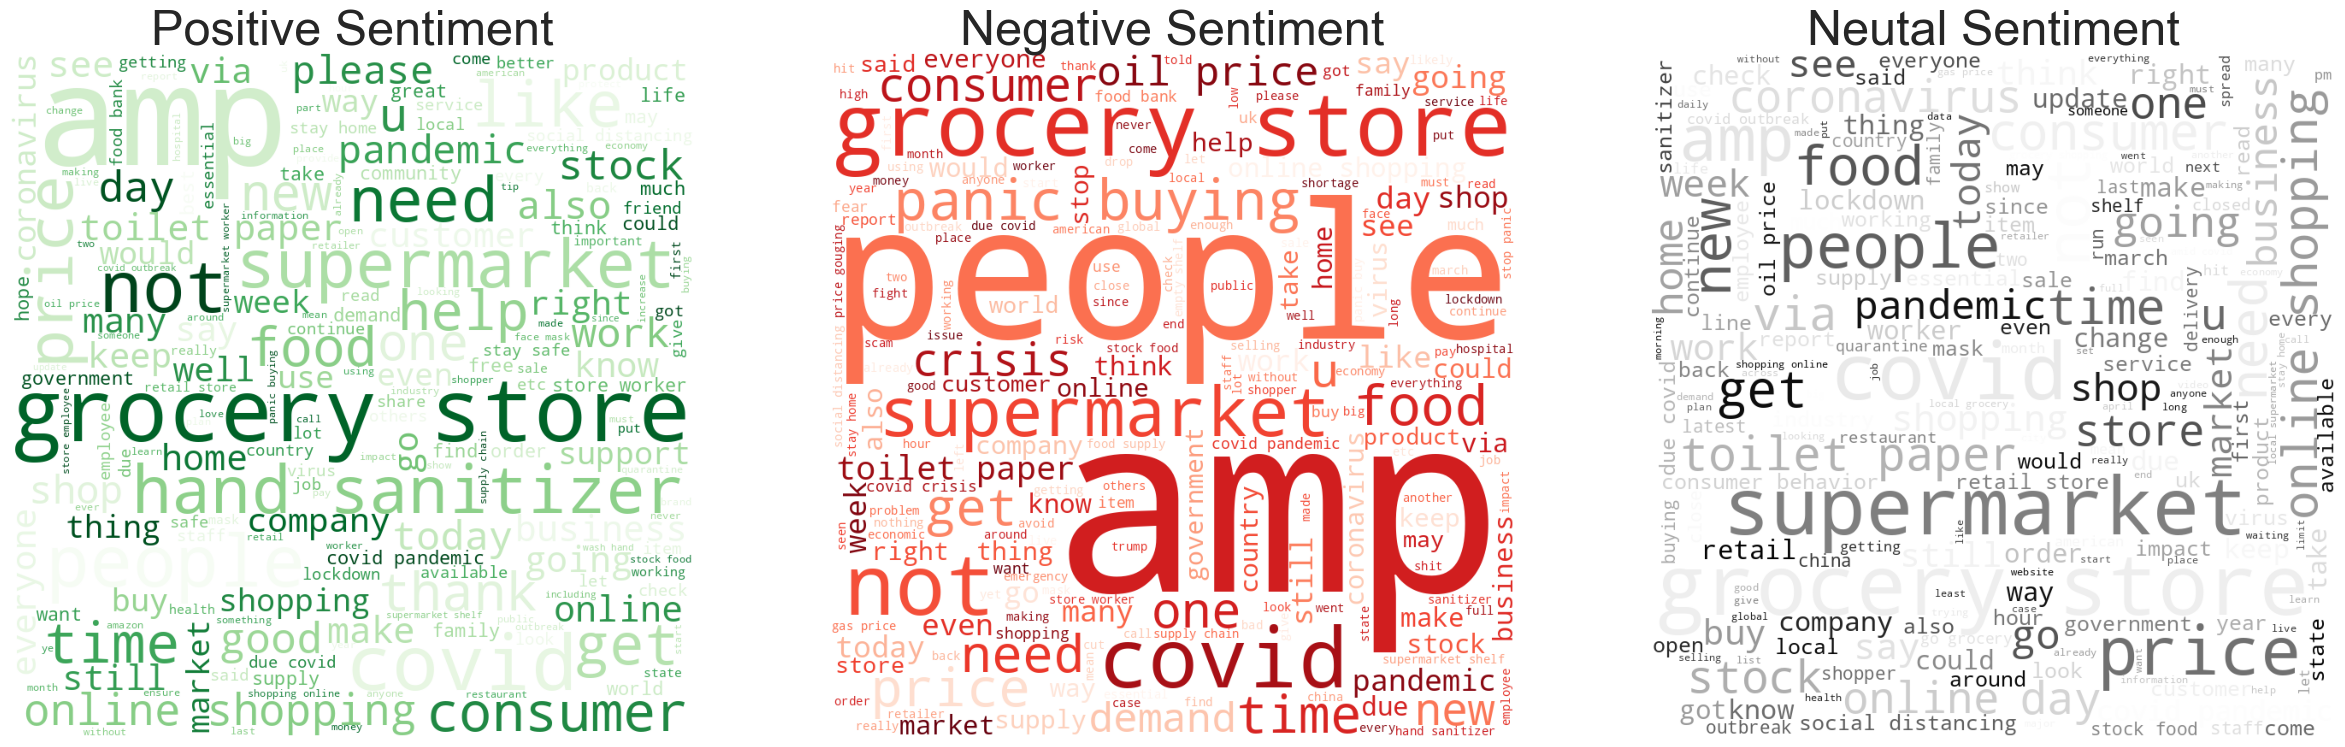

In [39]:
from wordcloud import WordCloud
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])

df_pos = df[df["Sentiment"]=="positive"]['OriginalTweet']
df_neg = df[df["Sentiment"]=="negative"]['OriginalTweet']
df_neu = df[df["Sentiment"]=="neutral"]['OriginalTweet']

words_list = df_pos.unique().tolist()
words = " ".join(words_list)
font_path = "/Library/Fonts/Arial.ttf"


wordcloud1 = WordCloud(width = 800, height = 800,
                background_color ='white',
                colormap="Greens",
                stopwords = stop_words,
                min_font_size = 10).generate(words)

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive Sentiment',fontsize=35);

words_list = df_neg.unique().tolist()
words = " ".join(words_list)


wordcloud2 = WordCloud(width = 800, height = 800,
                background_color ='white',
                colormap="Reds",
                stopwords = stop_words,
                min_font_size = 10).generate(words)
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative Sentiment',fontsize=35);

words_list = df_neu.unique().tolist()
words = " ".join(words_list)


wordcloud3 = WordCloud(width = 800, height = 800,
                background_color ='white',
                colormap="Greys",
                stopwords = stop_words,
                min_font_size = 10).generate(words)
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutal Sentiment',fontsize=35);

In [40]:
# Maps sentiment labels to integers for machine learning
l = {"neutral":0, "positive":1,"negative":2}
df['Sentiment'] = df['Sentiment'].map(l)
df

,OriginalTweet,Sentiment
0,,0
1,advice talk neighbour family exchange phone nu...,1
2,coronavirus australia woolworth give elderly d...,1
3,food stock not one empty please panic enough f...,1
4,ready go supermarket outbreak not paranoid foo...,2
...,...,...
3793,meanwhile supermarket israel people dance sing...,1
3794,panic buy lot non perishable item echo need fo...,2
3795,asst prof economics talking recent research co...,0
3796,gov need somethings instead biar je rakyat ass...,2


In [ ]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# splits the data
# x = df['OriginalTweet']: The tweet text is the feature (input).
# y = df['Sentiment']: The sentiment is the label (output).
x = df['OriginalTweet']
y = df['Sentiment']

# Splits the data into training (70%) and testing (30%) sets, ensuring the same class distribution in both sets using stratify=y
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y)

# Converts y_train and y_test into a one-hot encoded format (e.g., sentiment "0" becomes [1, 0, 0])
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [ ]:
from gensim.models import Word2Vec

# Preparing Text for Word2Vec
# Converts tweets in the training set (X_train) into lists of words. 
# Each tweet is tokenized into individual words (e.g., ["this", "is", "a", "tweet"])
tweets = X_train.tolist()
tweets = [tweet.split() for tweet in tweets]

# Uses Word2Vec to create word embeddings
w2v = Word2Vec(tweets, vector_size=200, window=5, workers=7, epochs=100, min_count=5)

In [ ]:
# most_similar: Finds words that are most similar to a given word based on vector similarity.
print(w2v.wv.most_similar('pay'))

[('paying', 0.43401867151260376), ('paid', 0.433923602104187), ('salary', 0.318376362323761), ('qualify', 0.31288304924964905), ('payroll', 0.30316758155822754), ('wage', 0.2859591245651245), ('tax', 0.2804337441921234), ('work', 0.27785226702690125), ('bonus', 0.27781203389167786), ('afford', 0.273368775844574)]


In [ ]:
print(w2v.wv.most_similar('covid'))

[('coronavirus', 0.5900986194610596), ('global', 0.31425726413726807), ('virus', 0.31221604347229004), ('corona', 0.31155094504356384), ('consumer', 0.29474401473999023), ('business', 0.2806051969528198), ('read', 0.2782876193523407), ('help', 0.27611300349235535), ('may', 0.27084994316101074), ('continue', 0.2613224983215332)]


In [ ]:
# doesnt_match: Identifies the word that doesn’t fit semantically in a lis
w2v.wv.doesnt_match(['grocery', 'covid', 'coronavirus'])

'grocery'

In [ ]:
# Determines the maximum length of a tweet in the training data to standardize input lengths later.
# This is done by measuring the length of each tweet (len(x)) and finding the maximum
max_len = np.max(X_train.apply(lambda x :len(x)))
max_len

261

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#creating embedding matrix

# Converts the text data into numerical format:
# fit_on_texts: Fits the tokenizer on the training data to build a vocabulary.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_length = len(tokenizer.word_index) + 1

# Transforms tweets into sequences of integers where each 
# word is replaced by its index (texts_to_sequences).
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Ensures that all tweet sequences are of the same length (max_len)
# of shorter, it's padded with zeros
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

print(vocab_length)


# Creates an embedding_matrix of shape (vocab_length, embedding_dim)
embedding_dim = 200
embedding_matrix = np.zeros((vocab_length, embedding_dim))

# For each word in the vocabulary
for word, i in tokenizer.word_index.items():
    # If the word is present in the Word2Vec model, 
    # its pre-trained embedding is added to the matrix.
    # Words not found in the Word2Vec model remain as zeros
    if word in w2v.wv:
        embedding_matrix[i] = w2v.wv[word]


25210


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout,GlobalMaxPooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
# Define the model
# A linear stack of layers is created using the Sequential API
model = Sequential()

"""
Adding an Embedding Layer
The first layer of your deep learning model is an embedding layer, 
which uses the Word2Vec embeddings
The embedding layer is like a dictionary for the model. 
When it sees a word, it looks up the corresponding vector of numbers.
"""
# Embedding layer with the pre-trained Word2Vec weights
model.add(Embedding(input_dim=vocab_length,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_len,  # max length of input sequences
                    trainable=False))

"""Adding LSTM Layers with Bidirectional Wrapping
The second LSTM and dropout layer follow the same logic but with 128 units in the LSTM
"""
model.add(Bidirectional(LSTM(264, return_sequences=True, kernel_regularizer=l2(0.0002))))

model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.0002))))

# Adding Pooling, Dense Layers, and Dropout
model.add(Dropout(0.3))

model.add(GlobalMaxPooling1D()) # Reduces the sequence to its most important features by taking the maximum value for each feature.

# First two Dense layers with 128 units each apply the ReLU activation (good for general learning tasks).
model.add(Dense(128, activation='relu'))

model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))

model.add(Dropout(0.2))

# Final Dense layer with 3 units outputs a probability for each class using the softmax activation function (used for classification).
model.add(Dense(3, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy'  , metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     5,042,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,042,000 (19.23 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,042,000 (19.23 MB)

In [ ]:
"""TRAIN MODEL"""
num_epochs = 10
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 943s 957ms/step - accuracy: 0.6467 - loss: 1.0245 - val_accuracy: 0.7816 - val_loss: 0.7109
Epoch 2/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 968s 984ms/step - accuracy: 0.7984 - loss: 0.6720 - val_accuracy: 0.8086 - val_loss: 0.6533
Epoch 3/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 1243s 1s/step - accuracy: 0.8357 - loss: 0.5961 - val_accuracy: 0.8209 - val_loss: 0.6484
Epoch 4/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 1015s 1s/step - accuracy: 0.8561 - loss: 0.5564 - val_accuracy: 0.8236 - val_loss: 0.6763
Epoch 5/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 1734s 2s/step - accuracy: 0.8757 - loss: 0.5261 - val_accuracy: 0.8289 - val_loss: 0.7063
Epoch 6/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 1767s 2s/step - accuracy: 0.8916 - loss: 0.5060 - val_accuracy: 0.8238 - val_loss: 0.7850


In [ ]:
# Evaluating the Model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

# Creates graphs showing how accuracy and loss evolve during training.
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

print(f"Accuracy on training data is:- {acc[-1]*100} %")
print(f"Loss {loss[-1]*100}")

print(f"Accuracy on validation data is:- {val_acc[-1]*100} %")
print(f"Loss {val_loss[-1]*100}")

NameError: name 'history' is not defined

In [ ]:
# Saves the model and tokenizer for future use
# By saving, the model can be reused for predictions or further training without retraining from scratch.
model.save("COVID_NLP4.keras")

NameError: name 'model' is not defined

In [28]:

joblib.dump(tokenizer, 'tokenizer4.joblib')

['tokenizer4.joblib']

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import joblib


# Load the model
# This allows us to use the pre-trained model (after training has been completed) 
# to make predictions on new data or evaluate its performance without retraining it from scratch
model = load_model('COVID_NLP4.keras')
# Load the model from the specified file
tokenizer = joblib.load('tokenizer4.joblib')

# X_test = tokenizer.texts_to_sequences(X_test)
# X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

2024-11-17 12:39:46.181277: W tensorflow/core/framework/op_kernel.cc:1818] OP_REQUIRES failed at cast_op.cc:122 : UNIMPLEMENTED: Cast string to float is not supported


UnimplementedError: Graph execution error:

Detected at node sequential_1/Cast defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/opt/homebrew/Cellar/python@3.11/3.11.10/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/opt/homebrew/Cellar/python@3.11/3.11.10/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/opt/homebrew/Cellar/python@3.11/3.11.10/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/6t/yvg59bhn1h15pmd_xnzgxvbh0000gn/T/ipykernel_42495/114338856.py", line 12, in <module>

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 432, in evaluate

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 165, in one_step_on_iterator

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 154, in one_step_on_data

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 82, in test_step

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/keras/src/models/sequential.py", line 213, in call

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/keras/src/models/functional.py", line 174, in call

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/keras/src/models/functional.py", line 280, in _standardize_inputs

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/keras/src/models/functional.py", line 238, in _convert_inputs_to_tensors

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/keras/src/ops/core.py", line 917, in convert_to_tensor

  File "/Users/kale/development/slang-aware-hate-speech/venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/core.py", line 132, in convert_to_tensor

Cast string to float is not supported
	 [[{{node sequential_1/Cast}}]] [Op:__inference_one_step_on_iterator_2396]

## Allow the embedding layer to modify the word2vec weights 

-You're defining a fresh architecture (or modifying a previous one) to see if a different configuration (e.g., changing the embedding layer to be trainable) improves performance.
-

In [33]:
# Define the model
model = Sequential()

# Embedding layer with the pre-trained Word2Vec weights
model.add(Embedding(input_dim=vocab_length,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_len,  # max length of input sequences
                    trainable=True))


model.add(Bidirectional(LSTM(264, return_sequences=True, kernel_regularizer=l2(0.0002))))

model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.0002))))

model.add(Dropout(0.3))

model.add(GlobalMaxPooling1D())

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))

model.add(Dropout(0.3))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))

model.add(Dropout(0.3))

model.add(Dense(3, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy'  , metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     5,042,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,042,000 (19.23 MB)

 Trainable params: 5,042,000 (19.23 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
num_epochs = 10
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train,6t y_train, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 1793s 2s/step - accuracy: 0.6457 - loss: 1.0525 - val_accuracy: 0.8005 - val_loss: 0.6848
Epoch 2/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 1702s 2s/step - accuracy: 0.8303 - loss: 0.6089 - val_accuracy: 0.8395 - val_loss: 0.5763
Epoch 3/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 1736s 2s/step - accuracy: 0.8851 - loss: 0.4612 - val_accuracy: 0.8496 - val_loss: 0.5773
Epoch 4/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 6576s 7s/step - accuracy: 0.9171 - loss: 0.3739 - val_accuracy: 0.8463 - val_loss: 0.5893
Epoch 5/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 1807s 2s/step - accuracy: 0.9390 - loss: 0.3126 - val_accuracy: 0.8354 - val_loss: 0.6542


In [35]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

422/422 ━━━━━━━━━━━━━━━━━━━━ 204s 483ms/step - accuracy: 0.8392 - loss: 0.5745
Test Loss: 0.5762965083122253
Test Accuracy: 0.8394750356674194


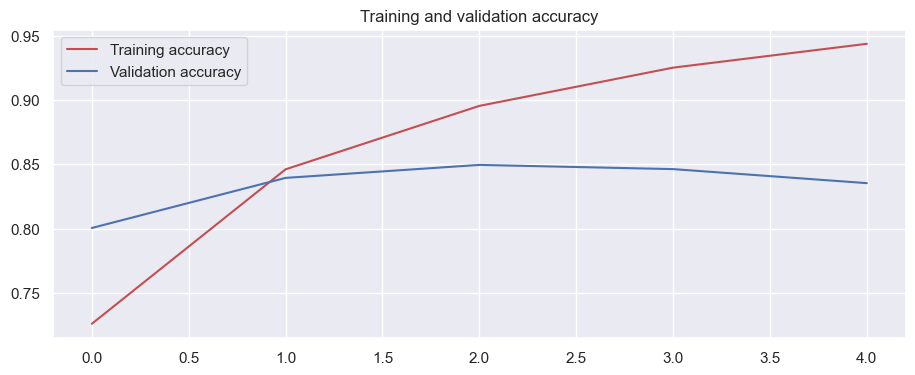

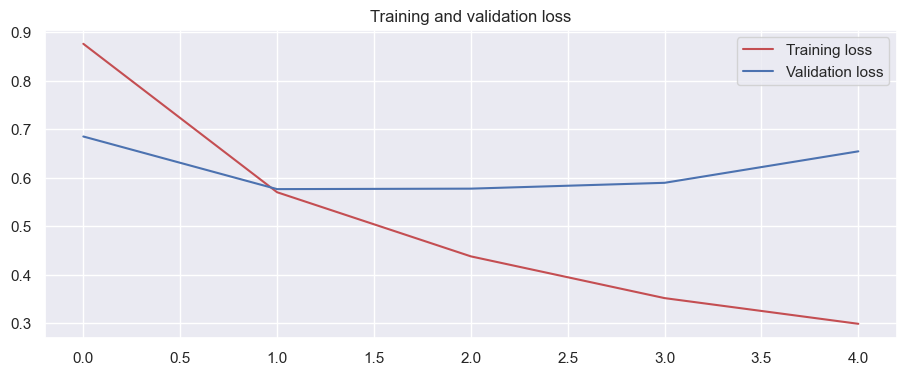

Accuracy on training data is:- 94.36570405960083 %
Loss 29.86362874507904
Accuracy on validation data is:- 83.53970646858215 %
Loss 65.41916131973267


In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

print(f"Accuracy on training data is:- {acc[-1]*100} %")
print(f"Loss {loss[-1]*100}")

print(f"Accuracy on validation data is:- {val_acc[-1]*100} %")
print(f"Loss {val_loss[-1]*100}")

In [37]:
model.save("COVID_NLP5.keras")

In [38]:
joblib.dump(tokenizer, 'tokenizer5.joblib')

['tokenizer5.joblib']